In [2]:
import sys
import os
gpu_num = 3 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from simulations.experimental_losses import *

sim.BATCH_SIZE = 128
sim.ebno_dbs = np.linspace(-5., 15., 21)
sim.MAX_MC_ITER = 500
# sim.ebno_dbs = np.linspace(-5., 15., 11)
# sim.MAX_MC_ITER = 20


# Frequency Domain Simulations
### Validation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 9.4643e-04 | 8.4805e-01 |       80633 |    85196800 |        21710 |       25600 |        35.0 |reached max iter       
     -4.0 | 3.5316e-04 | 4.6539e-01 |       30088 |    85196800 |        11914 |       25600 |        26.0 |reached max iter       
     -3.0 | 1.2123e-04 | 1.8883e-01 |       10328 |    85196800 |         4834 |       25600 |        25.8 |reached max iter       
     -2.0 | 4.1891e-05 | 6.9922e-02 |        3569 |    85196800 |         1790 |       25600 |        25.9 |reached max iter       
     -1.0 | 1.6796e-05 | 2.7656e-02 |        1431 |    85196800 |          708 |       25600 |        25.5 |reached max iter       
      0.0 | 4.8006e-06 | 8.7891e-03 |         409 |    85196800 |          225 |     

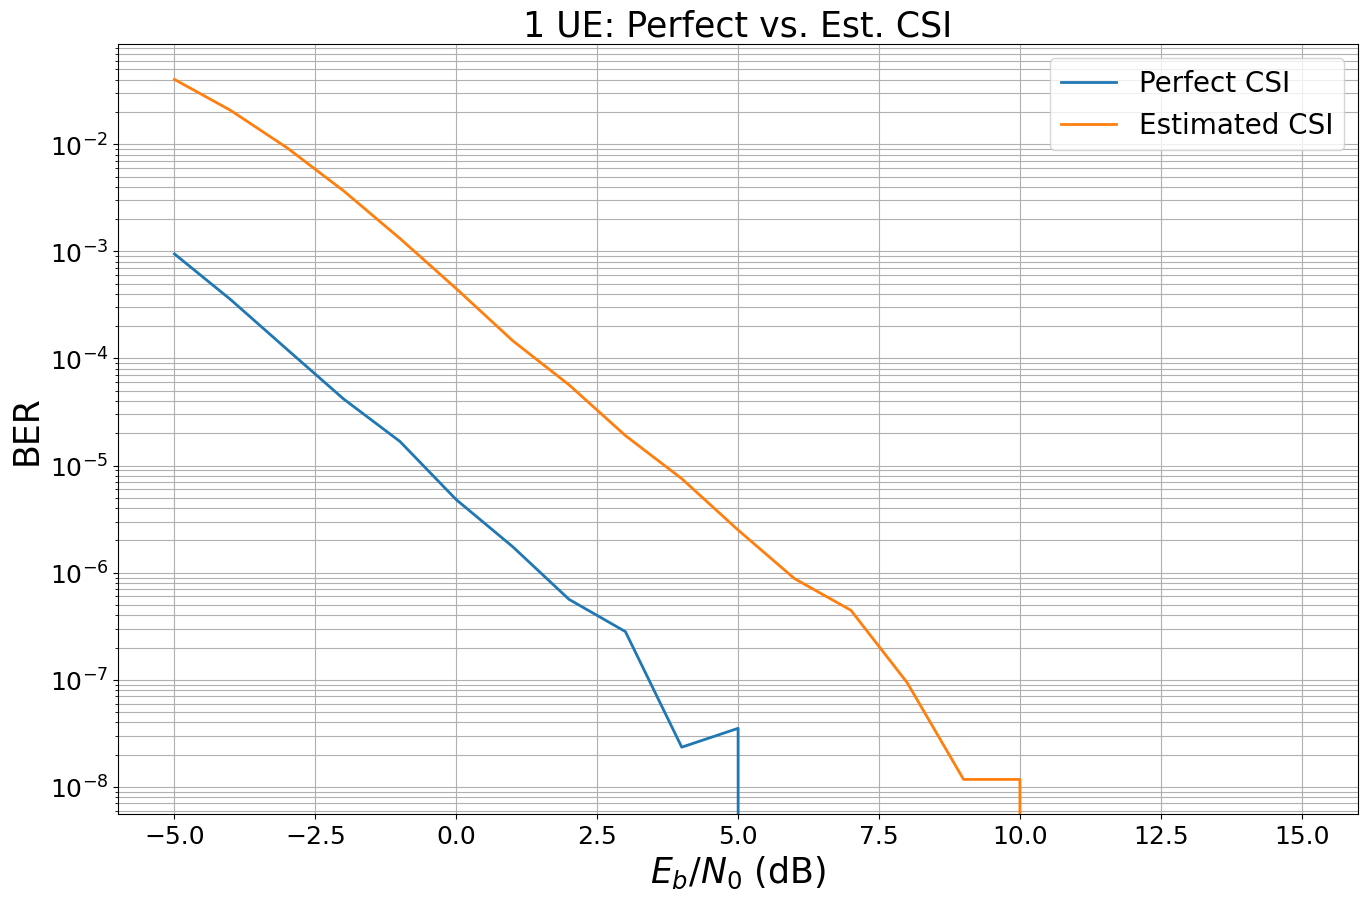

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = True
model = Model(**model_parameters)
simulate_model(model, f"Perfect CSI")
model_parameters["perfect_csi"] = False
model = Model(**model_parameters)
simulate_model(model, f"Estimated CSI")
ber_plots.title = "1 UE: Perfect vs. Est. CSI"
ber_plots()
with open("bers/report/frequency/perf_vs_est_csi.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 9.1261e-03 | 9.7590e-01 |      777515 |    85196800 |        24983 |       25600 |        40.3 |reached max iter       
     -4.0 | 7.0222e-03 | 8.7449e-01 |      598267 |    85196800 |        22387 |       25600 |        29.5 |reached max iter       
     -3.0 | 5.9080e-03 | 7.2945e-01 |      503341 |    85196800 |        18674 |       25600 |        29.5 |reached max iter       
     -2.0 | 4.8559e-03 | 6.0805e-01 |      413705 |    85196800 |        15566 |       25600 |        29.6 |reached max iter       
     -1.0 | 4.3208e-03 | 5.1340e-01 |      368118 |    85196800 |        13143 |       25600 |        29.6 |reached max iter       
      0.0 | 3.8323e-03 | 4.4625e-01 |      326502 |    85196800 |        11424 |     

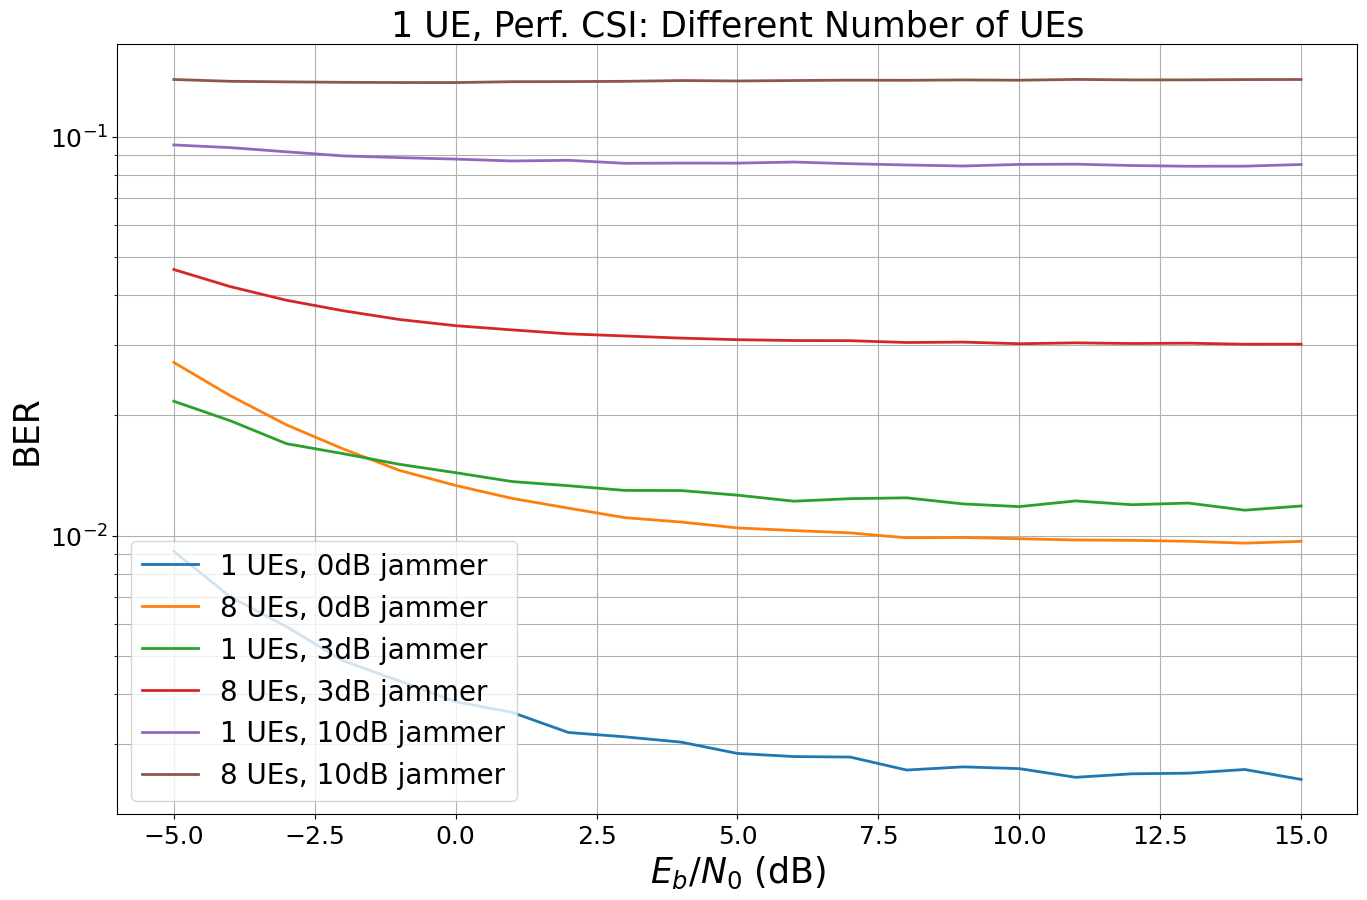

In [4]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["perfect_csi"] = True
model_parameters["jammer_present"] = True
for jammer_power_db in [0, 3, 10]:
    for num_ut in [1, 8]:
        model_parameters["num_ut"] = num_ut
        model_parameters["jammer_power"] = db_to_linear(jammer_power_db)
        model = Model(**model_parameters)
        simulate_model(model, f"{num_ut} UEs, {jammer_power_db}dB jammer")

ber_plots.title = "1 UE, Perf. CSI: Different Number of UEs"
ber_plots()
with open("bers/report/frequency/num_ues.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

### Jammer Mitigation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.4940e-02 | 1.0000e+00 |     5760836 |   104857600 |        25600 |       25600 |        49.6 |reached max iter       
     -4.0 | 3.7303e-02 | 1.0000e+00 |     3911542 |   104857600 |        25600 |       25600 |        39.1 |reached max iter       
     -3.0 | 2.3664e-02 | 1.0000e+00 |     2481302 |   104857600 |        25600 |       25600 |        39.0 |reached max iter       
     -2.0 | 1.4184e-02 | 1.0000e+00 |     1487285 |   104857600 |        25600 |       25600 |        39.0 |reached max iter       
     -1.0 | 8.0519e-03 | 1.0000e+00 |      844306 |   104857600 |        25600 |       25600 |        39.4 |reached max iter       
      0.0 | 4.2765e-03 | 9.9488e-01 |      448426 |   104857600 |        25469 |     

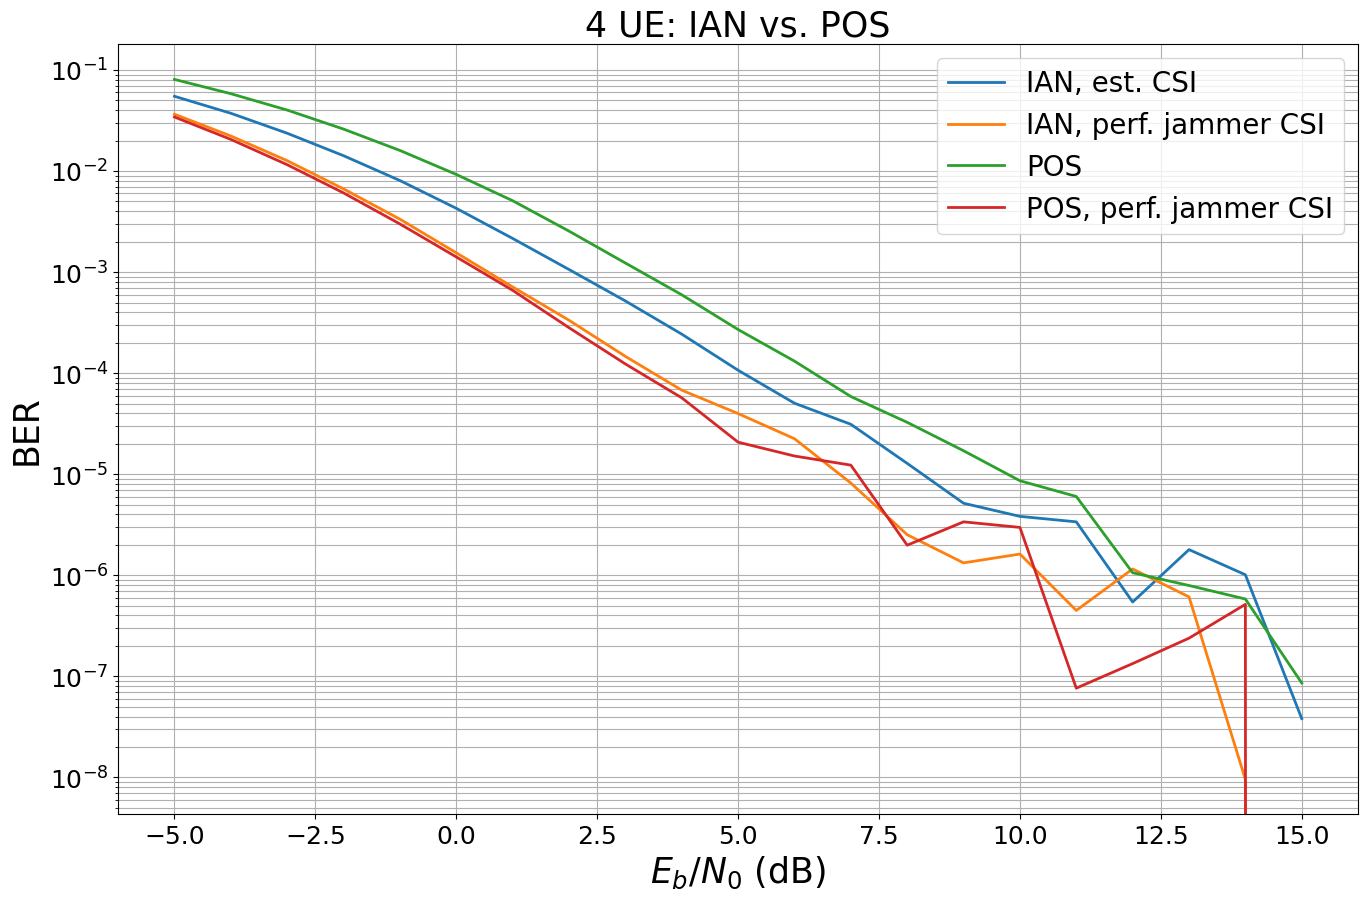

In [5]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["num_silent_pilot_symbols"] = 6

model_parameters["jammer_mitigation"] = "ian"
model = Model(**model_parameters)
simulate_model(model, f"IAN, est. CSI")
model_parameters["perfect_jammer_csi"] = True
model = Model(**model_parameters)
simulate_model(model, f"IAN, perf. jammer CSI")
model_parameters["perfect_jammer_csi"] = False

model_parameters["jammer_mitigation"] = "pos"
model = Model(**model_parameters)
simulate_model(model, f"POS")
model_parameters["perfect_jammer_csi"] = True
model = Model(**model_parameters)
simulate_model(model, f"POS, perf. jammer CSI")

ber_plots.title = "4 UE: IAN vs. POS"
ber_plots()
with open("bers/report/frequency/ian_vs_pos.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.5898e-01 | 1.0000e+00 |    16670092 |   104857600 |        25600 |       25600 |        52.4 |reached max iter       
     -4.0 | 1.4627e-01 | 1.0000e+00 |    15337987 |   104857600 |        25600 |       25600 |        42.6 |reached max iter       
     -3.0 | 1.3591e-01 | 1.0000e+00 |    14251604 |   104857600 |        25600 |       25600 |        42.4 |reached max iter       
     -2.0 | 1.2749e-01 | 1.0000e+00 |    13368791 |   104857600 |        25600 |       25600 |        42.3 |reached max iter       
     -1.0 | 1.2077e-01 | 1.0000e+00 |    12663521 |   104857600 |        25600 |       25600 |        42.5 |reached max iter       
      0.0 | 1.1545e-01 | 1.0000e+00 |    12106253 |   104857600 |        25600 |     

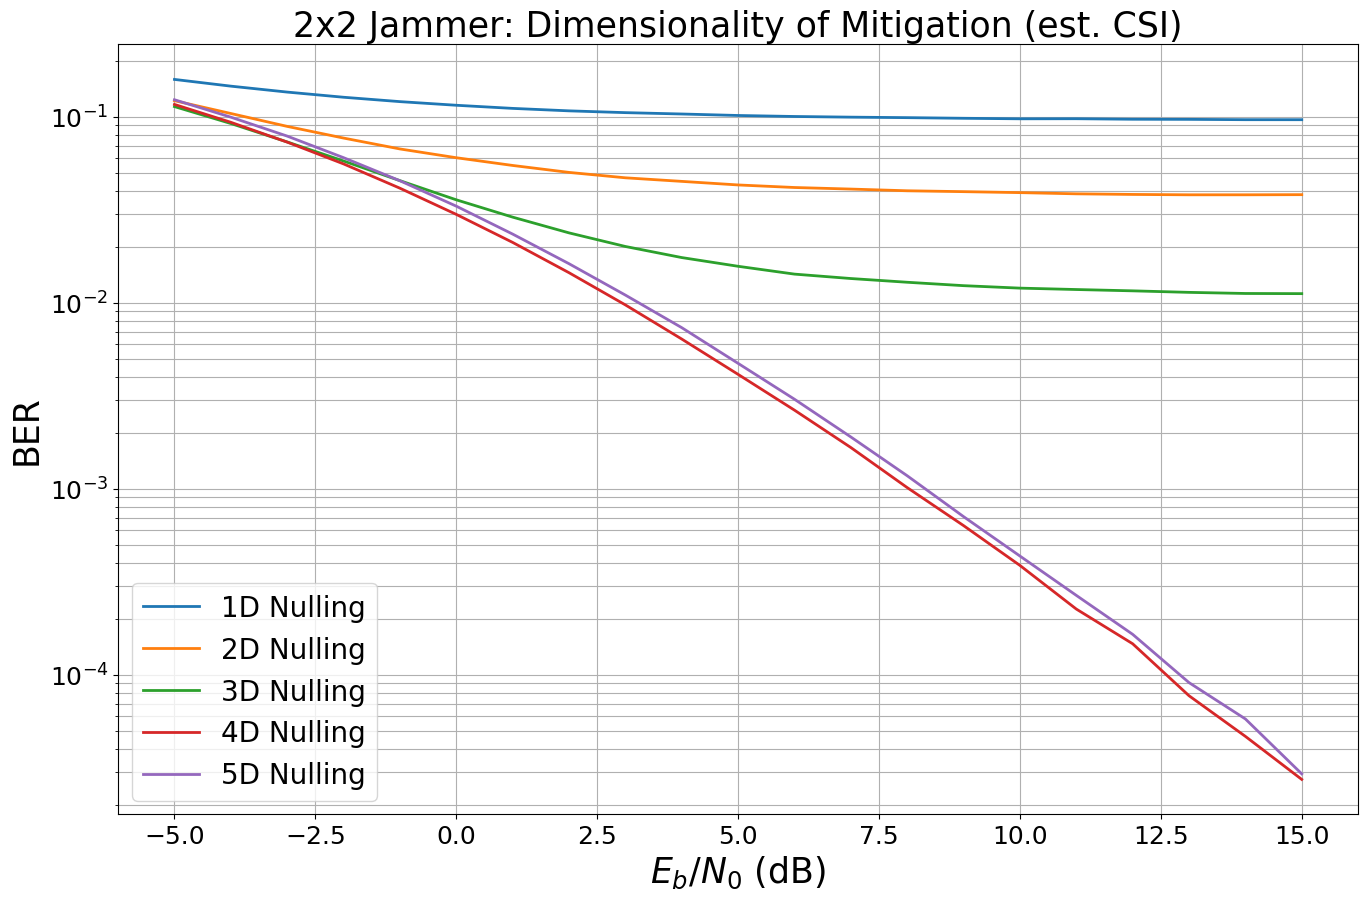

In [6]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_mitigation"] = "pos"
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 2

for d in [1, 2, 3, 4, 5]:
    model_parameters["jammer_mitigation_dimensionality"] = d
    model = Model(**model_parameters)
    simulate_model(model, f"{d}D Nulling")
    
ber_plots.title = "2x2 Jammer: Dimensionality of Mitigation (est. CSI)"
ber_plots()
with open("bers/report/frequency/mitigation_dim.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.6677e-02 | 1.0000e+00 |     3976704 |    85196800 |        25600 |       25600 |        64.9 |reached max iter       
     -4.0 | 2.5316e-02 | 1.0000e+00 |     2156849 |    85196800 |        25600 |       25600 |        54.8 |reached max iter       
     -3.0 | 1.2154e-02 | 1.0000e+00 |     1035492 |    85196800 |        25600 |       25600 |        54.9 |reached max iter       
     -2.0 | 5.2418e-03 | 9.9746e-01 |      446584 |    85196800 |        25535 |       25600 |        55.2 |reached max iter       
     -1.0 | 2.0040e-03 | 8.5160e-01 |      170734 |    85196800 |        21801 |       25600 |        54.8 |reached max iter       
      0.0 | 7.5333e-04 | 4.6766e-01 |       64181 |    85196800 |        11972 |     

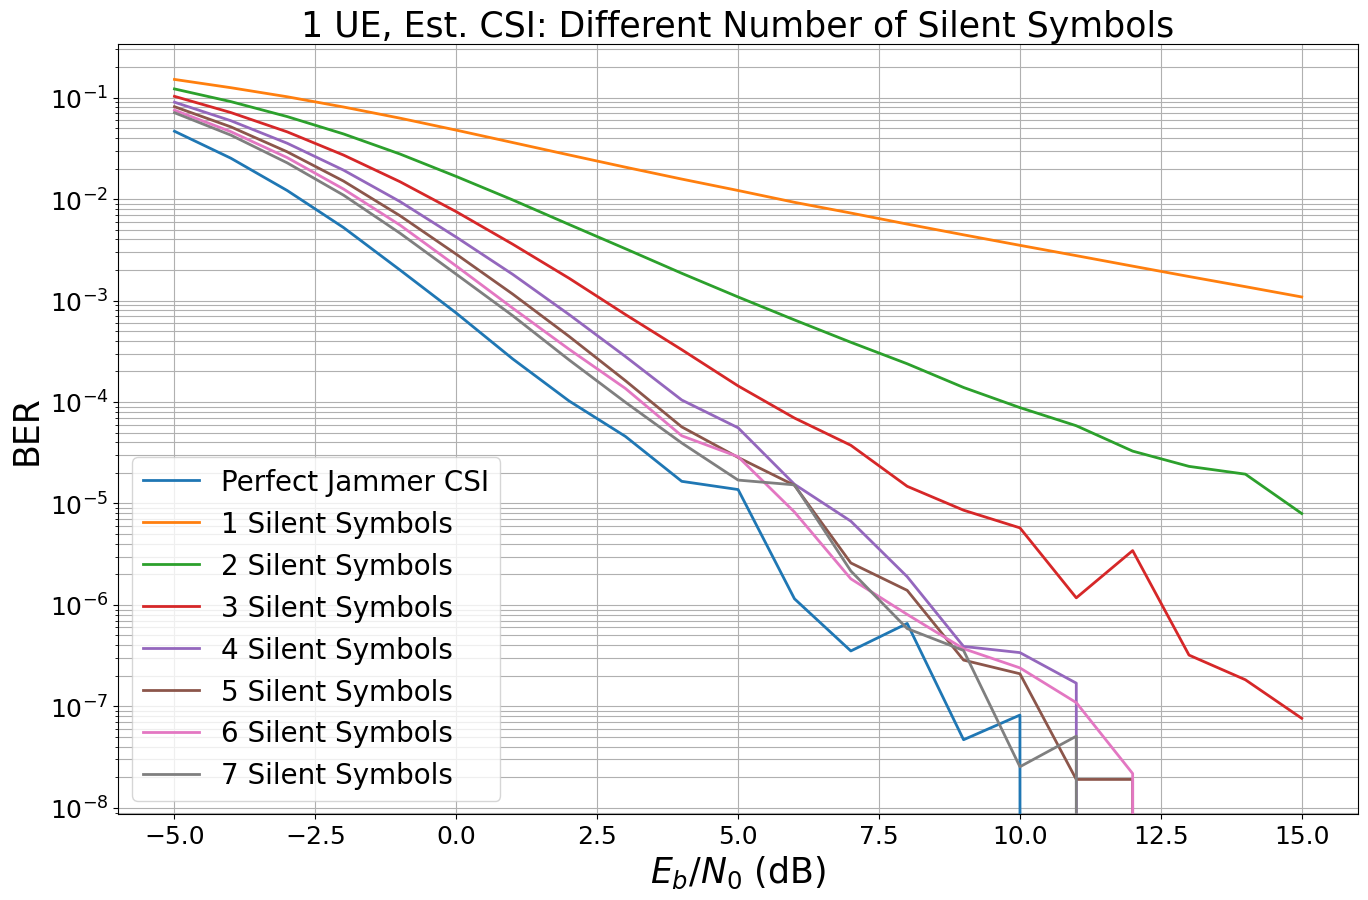

In [7]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1

model_parameters["perfect_jammer_csi"] = True
model = Model(**model_parameters)
simulate_model(model, f"Perfect Jammer CSI")

model_parameters["perfect_jammer_csi"] = False
for i in range(1, 8):
    model_parameters["num_silent_pilot_symbols"] = i
    model = Model(**model_parameters)
    simulate_model(model, f"{i} Silent Symbols")

ber_plots.title = "1 UE, Est. CSI: Different Number of Silent Symbols"
ber_plots()
with open("bers/report/frequency/num_silent.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.5608e-01 | 1.0000e+00 |    20922629 |    45875200 |        25600 |       25600 |        39.3 |reached max iter       
     -4.0 | 4.5594e-01 | 1.0000e+00 |    20916177 |    45875200 |        25600 |       25600 |        29.4 |reached max iter       
     -3.0 | 4.5584e-01 | 1.0000e+00 |    20911735 |    45875200 |        25600 |       25600 |        29.4 |reached max iter       
     -2.0 | 4.5572e-01 | 1.0000e+00 |    20906198 |    45875200 |        25600 |       25600 |        29.3 |reached max iter       
     -1.0 | 4.5575e-01 | 1.0000e+00 |    20907617 |    45875200 |        25600 |       25600 |        29.4 |reached max iter       
      0.0 | 4.5575e-01 | 1.0000e+00 |    20907470 |    45875200 |        25600 |     

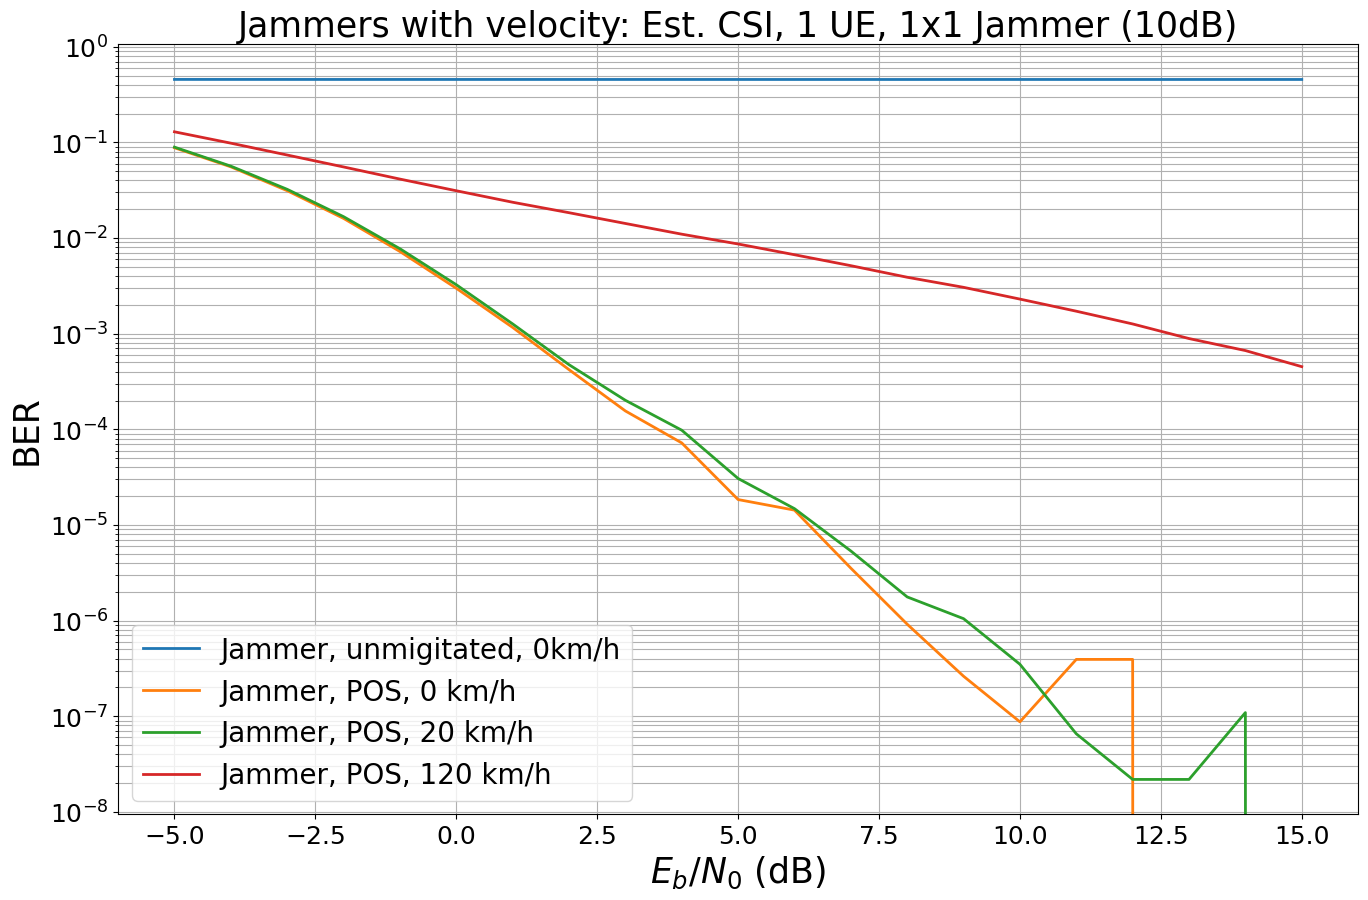

In [8]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx_ant"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
kmhs = [0, 20, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammers with velocity: Est. CSI, 1 UE, 1x1 Jammer (10dB)"
ber_plots()
with open("bers/report/frequency/velocity_mitigation.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 8.2543e-02 | 1.0000e+00 |     3786675 |    45875200 |        25600 |       25600 |        43.6 |reached max iter       
     -4.0 | 5.1093e-02 | 1.0000e+00 |     2343885 |    45875200 |        25600 |       25600 |        33.7 |reached max iter       
     -3.0 | 2.8317e-02 | 1.0000e+00 |     1299067 |    45875200 |        25600 |       25600 |        33.8 |reached max iter       
     -2.0 | 1.3868e-02 | 1.0000e+00 |      636190 |    45875200 |        25600 |       25600 |        33.6 |reached max iter       
     -1.0 | 6.1244e-03 | 9.8930e-01 |      280958 |    45875200 |        25326 |       25600 |        33.8 |reached max iter       
      0.0 | 2.4618e-03 | 7.9996e-01 |      112936 |    45875200 |        20479 |     

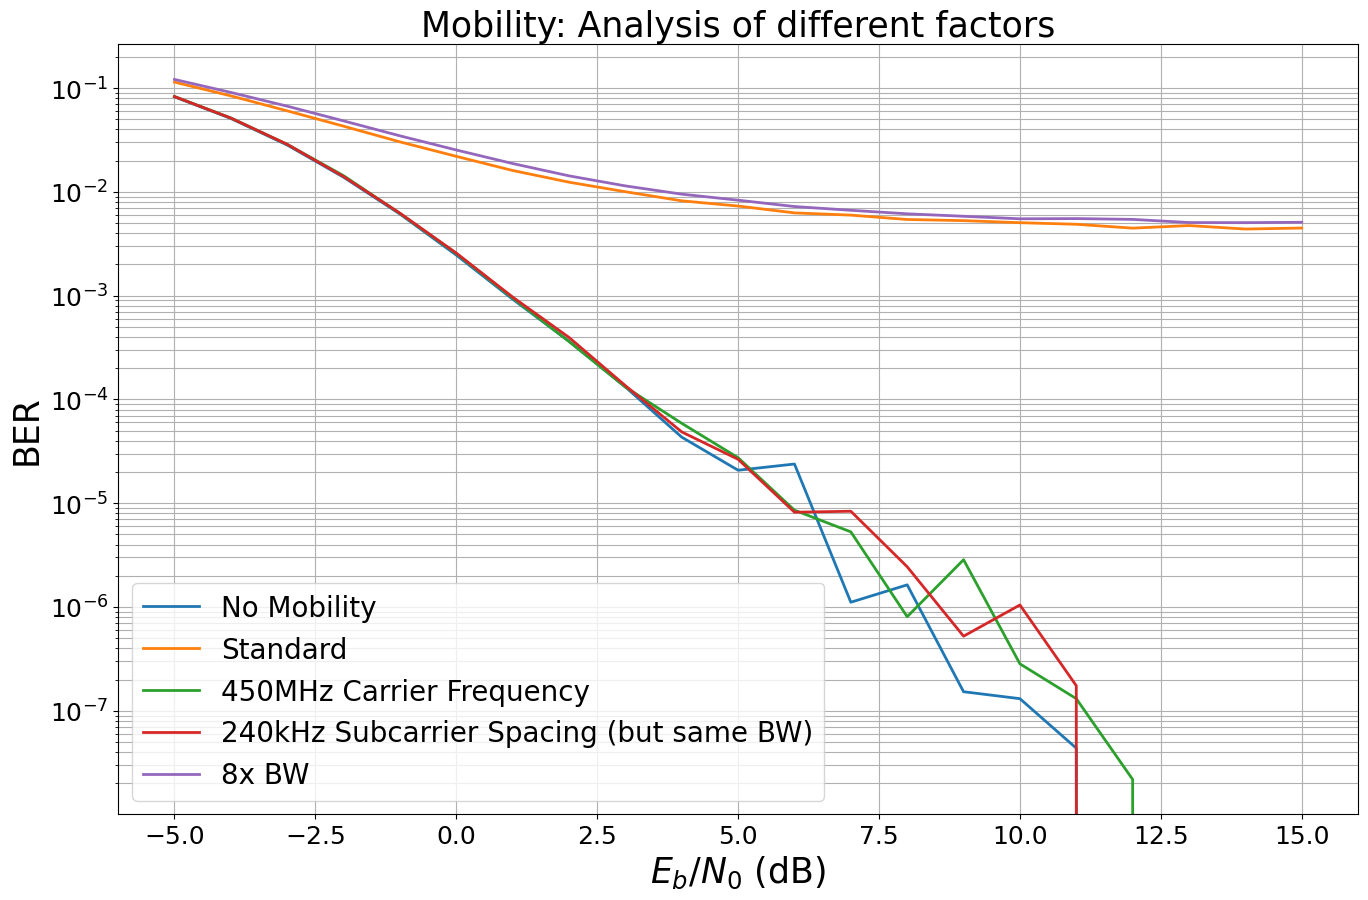

In [9]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["cyclic_prefix_length"] = 0

model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx_ant"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model = Model(**model_parameters)
simulate_model(model, "No Mobility")
velocity_kmh = 120
velocity_mps = velocity_kmh / 3.6
model_parameters["min_ut_velocity"] = velocity_mps
model_parameters["max_ut_velocity"] = velocity_mps
model_parameters["min_jammer_velocity"] = velocity_mps
model_parameters["max_jammer_velocity"] = velocity_mps

model = Model(**model_parameters)
simulate_model(model, f"Standard")
model = Model(carrier_frequency=4.5e8, **model_parameters)
simulate_model(model, f"450MHz Carrier Frequency")
model = Model(subcarrier_spacing=240e3, fft_size=16, **model_parameters)
simulate_model(model, f"240kHz Subcarrier Spacing (but same BW)")
model = Model(fft_size=1024, **model_parameters)
simulate_model(model, f"8x BW")

ber_plots.title = "Mobility: Analysis of different factors"
ber_plots()
with open("bers/report/frequency/velocity_factors.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

### Coded Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6568e-04 | 4.1641e-03 |      174115 |   655360000 |          533 |      128000 |       224.1 |reached max iter       
     -4.0 | 1.2575e-04 | 1.8672e-03 |       82414 |   655360000 |          239 |      128000 |       220.1 |reached max iter       
     -3.0 | 7.1790e-05 | 8.6719e-04 |       47048 |   655360000 |          111 |      128000 |       219.7 |reached max iter       
     -2.0 | 3.5767e-05 | 4.5313e-04 |       23440 |   655360000 |           58 |      128000 |       220.3 |reached max iter       
     -1.0 | 2.3949e-05 | 2.7344e-04 |       15695 |   655360000 |           35 |      128000 |       219.5 |reached max iter       
      0.0 | 8.9523e-06 | 1.0938e-04 |        5867 |   655360000 |           14 |     

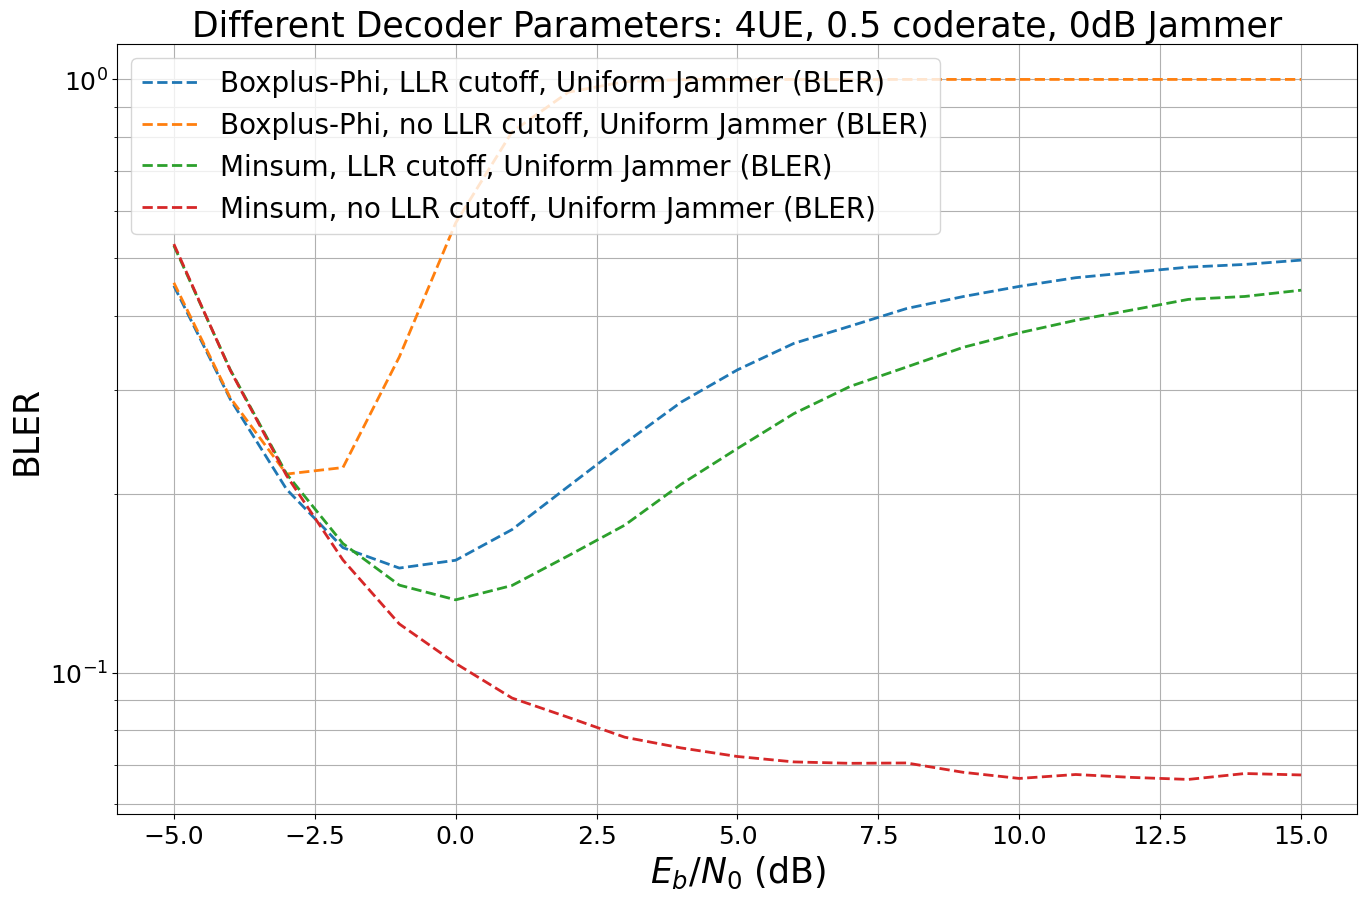

In [10]:
# TODO change iterations
sim.MAX_MC_ITER = 1000
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters

model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 4
model_parameters["coderate"] = 0.5
decoder_parameters["cn_type"] = "boxplus-phi"
decoder_parameters["num_iter"] = 20

model = Model(**model_parameters)
simulate_model(model, "Boxplus-Phi, LLR cutoff, no Jammer")

model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(0.)

model = Model(**model_parameters)
simulate_model(model, "Boxplus-Phi, LLR cutoff, Uniform Jammer", add_bler=True)

model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Boxplus-Phi, no LLR cutoff, Uniform Jammer", add_bler=True)

decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
simulate_model(model, "Minsum, LLR cutoff, Uniform Jammer", add_bler=True)

model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Minsum, no LLR cutoff, Uniform Jammer", add_bler=True)

ber_plots.title = "Different Decoder Parameters: 4UE, 0.5 coderate, 0dB Jammer"
ber_plots(show_ber=False)
with open("bers/report/frequency/bler_params.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

# Time Domain Simulations

In [11]:
sim.BATCH_SIZE = 4
sim.ebno_dbs = np.linspace(-5., 15., 11)
sim.MAX_MC_ITER = 3000

### Validation 

Done in ..._long-ds notebook